In [3]:
"""
Example usage of aggregated NHCI drifter data v1.

Example code for loading and working with Spotter data from the NHCI
aggregated drifter dataset in Python .pickle format. Since all datasets
have the same variable names and structure, this example framework can
also be used for DWSD and microSWIFT drifters.

This notebook is based on the really nice example provided by Jacob Davis (davisjr@uw.edu)
"""

import os
import pickle
from datetime import datetime, timezone
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib.colors
import numpy as np

import xarray as xr
import xroms
import matplotlib.pyplot as plt
from wavespectra import read_ww3, read_swan, read_ndbc, read_netcdf
from wavespectra.input.swan import read_swans

DATA_DIRECTORY = '/vortexfs1/home/csherwood/proj/NOPP/buoy_data/'
DATA_FILENAME = 'hurricane_ian_spotter_data_v1.pickle'
#MODEL_DIRECTORY = '/vortexfs1/scratch/jwarner/Ian2022/ian10/'
MODEL_DIRECTORY = '/vortexfs1/share/usgs-share/Projects/Ian2022/ian10/drifters/'

# This runs the file with the new ndbc buoy input
#%run -i /vortexfs1/home/csherwood/src/wavespectra/wavespectra/input/ndbc.py

with open(os.path.join(DATA_DIRECTORY, DATA_FILENAME), 'rb') as handle:
    spotter = pickle.load(handle)

# `spotter` is a python dictionary of Pandas DataFrames, keyed by
# each drifter ID. The drifter ids can then be accessed as follows:
spotter_ids = list(spotter.keys())

In [4]:
# data to test one plot
spotter_id = 'SPOT-30068D'
only_waves = spotter[spotter_id]['energy_density'].notnull()
nw = len(spotter[spotter_id][only_waves].index)
dt = np.NaN*np.ones(nw)
hsmod = np.NaN*np.ones(nw)
hsobs = np.NaN*np.ones(nw)
tpmod = np.NaN*np.ones(nw)
tpobs = np.NaN*np.ones(nw)
mdirobs  = np.NaN*np.ones(nw)
mdirsobs = np.NaN*np.ones(nw)
mdirmod  = np.NaN*np.ones(nw)
mdirsmod = np.NaN*np.ones(nw)

ipt = 0 # index must stay below 100 or file names will be too long
for index, row in spotter[spotter_id][only_waves].iterrows():
    hsobs[ipt] = row['significant_height']
    tpobs[ipt] = row['peak_period']
    mdirobs[ipt] = row['mean_direction']
    mdirsobs[ipt]= row['mean_directional_spread']

    fn = "{}{:02d}.spc2d".format(spotter_id[5:], ipt)
    # print(fn)
    hsmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.hs().values )
    tpmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.tp().values )
    mdirmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.dpm().values )
    mdirsmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.dspr().values )

    ipt = ipt + 1

dt = spotter[spotter_id][only_waves].index


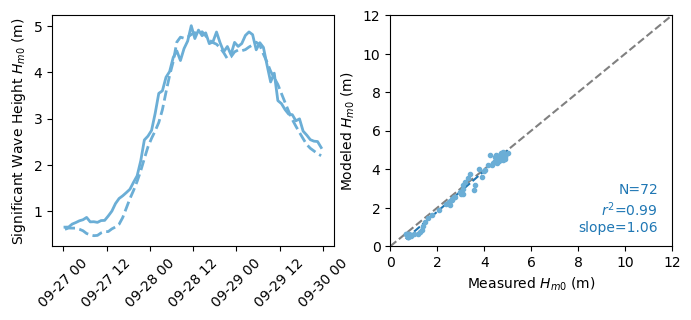

In [37]:
# two panel plot - test with one dataset
wcolors = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c']
rmse = np.sqrt( np.mean( (hsobs - hsmod)**2) )
ts = 'Model RMSE {:.2f}m'.format(rmse)
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8,3))
ax1.plot(dt, hsobs,linewidth=2,c=wcolors[2],label=spotter_id)
ax1.plot(dt, hsmod,'--',linewidth=2,c=wcolors[2],label=ts)
ax1.set_ylabel('Significant Wave Height $H_{m0}$ (m)')
# ax1.text(x=.95, y=.05, s=ts, fontsize=10, c='tab:blue',transform=ax1.transAxes,\
#                              horizontalalignment='right', verticalalignment='bottom')
ax1.legend(bbox_to_anchor=(1.5, .75),
          ncol=1, fancybox=True, shadow=True)
# plt.title(spotter_id)
ax1.tick_params(axis='x', rotation=45)

gradient, intercept, r_value, p_value, std_err = stats.linregress(hsobs,hsmod)
mn=np.min(hsobs)
mx=np.max(hsobs)
x1d=np.linspace(mn,mx,10)
y1d=gradient*x1d+intercept
ts = 'N={:.0f}\n$r^2$={:.2f}\nslope={:.2f}'.format( len(hsobs),r_value,gradient)
ax2.plot([0,12],[0,12],'--',c='gray')
ax2.plot(x1d,y1d,'--',c='tab:blue')
ax2.plot(hsobs,hsmod,'.',c=wcolors[2])
ax2.text(x=.95, y=.05, s=ts, fontsize=10, c='tab:blue',transform=ax2.transAxes,\
             horizontalalignment='right', verticalalignment='bottom')
ax2.set_ylabel('Modeled $H_{m0}$ (m)')
ax2.set_xlabel('Measured $H_{m0}$ (m)')
ax2.axis([0, 12, 0, 12])
  
plt.savefig(spotter_id+'_spotter_2panel.svg', bbox_inches='tight')
plt.show()

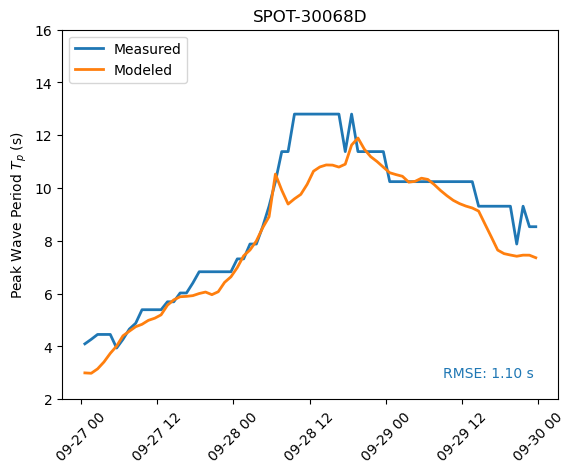

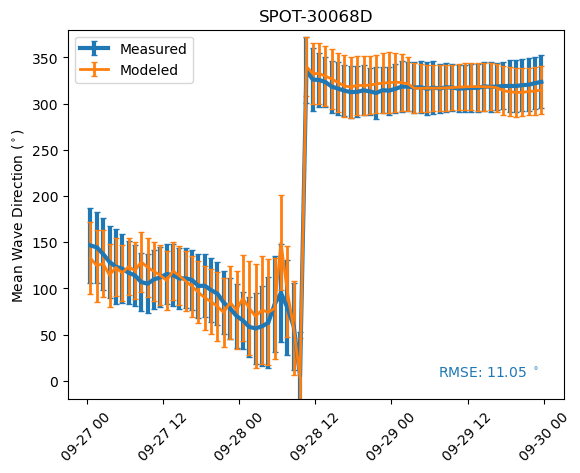

In [48]:
# test the plots with one dataset
%run -i /vortexfs1/home/csherwood/src/NOPP_Utilities/wave_plot_funcs.py

# plot_hs_ts(spotter_id, dt, hsobs, hsmod, show=True)
# plot_hs_scat(spotter_id, hsobs, hsmod, show=True)
plot_tp_ts(spotter_id, dt, tpobs, tpmod, show=True)
# plot_tp_scat(spotter_id, tpobs, tpmod, show=True)
plot_dir_ts(spotter_id, dt, mdirobs, mdirsobs, mdirmod, mdirsmod, show=True)
# plot_mdirs_scat(spotter_id, mdirsobs, mdirsmod, show=True)
# plot_mdir_scat(spotter_id, mdirobs, mdirmod, show=True)

0 SPOT-30068D
1.0658408446456322
1 SPOT-30097D
0.4831843111533984
2 SPOT-30096D
0.4131597181598891
3 SPOT-30104D
0.30520275017389115
4 SPOT-30024D
0.31876264341943805
5 SPOT-30065D
0.25174160744938984


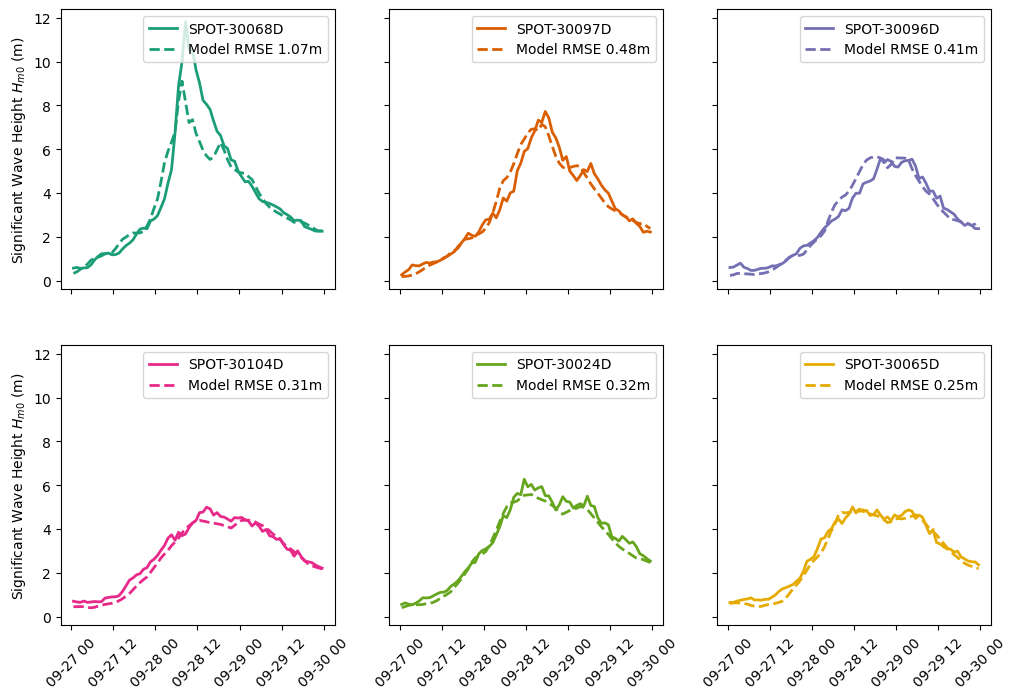

In [44]:
# make all plots
wcolors = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c'] # shades of blue
wcolors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'] # dark2 qualititative
fig, ax = plt.subplots(ncols=3,nrows=2, sharey=True, figsize=(12,8))
ax = np.ravel(ax)

for ispot, spotter_id in enumerate( spotter.keys() ):
    print(ispot, spotter_id)
    only_waves = spotter[spotter_id]['energy_density'].notnull()
    nw = len(spotter[spotter_id][only_waves].index)
    dt = np.NaN*np.ones(nw)
    hsmod = np.NaN*np.ones(nw)
    hsobs = np.NaN*np.ones(nw)
    tpmod = np.NaN*np.ones(nw)
    tpobs = np.NaN*np.ones(nw)
    mdirobs  = np.NaN*np.ones(nw)
    mdirsobs = np.NaN*np.ones(nw)
    mdirmod  = np.NaN*np.ones(nw)
    mdirsmod = np.NaN*np.ones(nw)
    
    ipt = 0 # index must stay below 100 or file names will be too long
    for index, row in spotter[spotter_id][only_waves].iterrows():
        # dt[ipt]= index
        hsobs[ipt] = row['significant_height']
        tpobs[ipt] = row['peak_period']
        mdirobs[ipt] = row['mean_direction']
        mdirsobs[ipt]= row['mean_directional_spread']
        
        fn = "{}{:02d}.spc2d".format(spotter_id[5:], ipt)
        # print(fn)
        hsmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.hs().values )
        tpmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.tp().values )
        mdirmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.dpm().values )
        mdirsmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.dspr().values )
                
        ipt = ipt + 1

    dt = spotter[spotter_id][only_waves].index
    
    # six panel plot
    rmse = np.sqrt( np.mean( (hsobs - hsmod)**2) )
    ts = 'Model RMSE {:.2f}m'.format(rmse)
    print(rmse)

    ax[0].set_ylabel('Significant Wave Height $H_{m0}$ (m)')
    ax[3].set_ylabel('Significant Wave Height $H_{m0}$ (m)')
    ax[3].tick_params(axis='x', rotation=45)
    ax[4].tick_params(axis='x', rotation=45)
    ax[5].tick_params(axis='x', rotation=45)

    ax[0].xaxis.set_ticklabels([])
    ax[1].xaxis.set_ticklabels([])
    ax[2].xaxis.set_ticklabels([])
    # ax[1].yaxis.set_ticklabels([])
    # ax[1].yaxis.set_ticklabels([])
    # ax[4].yaxis.set_ticklabels([])
    # ax[5].yaxis.set_ticklabels([])

    ax[ispot].plot(dt, hsobs,linewidth=2,c=wcolors[ispot],label=spotter_id)
    ax[ispot].plot(dt, hsmod,'--',linewidth=2,c=wcolors[ispot],label=ts)
    ax[ispot].legend(loc='upper right')
    
    # ax1.text(x=.95, y=.05, s=ts, fontsize=10, c='tab:blue',transform=ax1.transAxes,\
    #                              horizontalalignment='right', verticalalignment='bottom')
    # if(ispot==0):
    #     ax1.tick_params(axis='x', rotation=45)
    # if(ispot==5):
    #     ax1.legend(bbox_to_anchor=(1.5, .75),
    #       ncol=1, fancybox=True, shadow=True)

plt.show()
fig.savefig('multi_spotter_ts_6panel.svg', bbox_inches='tight')
    
    # These are the previous version of individual plots. They should be inside the spotter_id loop
    # plot_hs_ts(spotter_id, dt, hsobs, hsmod, show=False)
    # plot_hs_scat(spotter_id, hsobs, hsmod, show=False)
    # plot_tp_ts(spotter_id, dt, tpobs, tpmod, show=False)
    # plot_tp_scat(spotter_id, tpobs, tpmod, show=False)
    # plot_dir_ts(spotter_id, dt, mdirobs, mdirsobs, mdirmod, mdirsmod, show=False)
    # plot_mdirs_scat(spotter_id, mdirsobs, mdirsmod, show=False)
    # plot_mdir_scat(spotter_id, mdirobs, mdirmod, show=False)

0 SPOT-30068D
1 SPOT-30097D
2 SPOT-30096D
3 SPOT-30104D
4 SPOT-30024D
5 SPOT-30065D


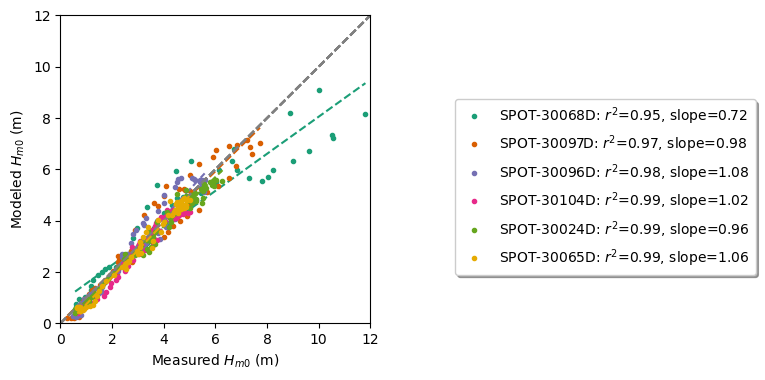

In [46]:
# all scatter on same panel
wcolors = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c'] # shades of blue
wcolors = ['#1b9e77','#d95f02','#7570b3','#e7298a','#66a61e','#e6ab02'] # dark2 qualititative
fig, ax = plt.subplots(ncols=1, figsize=(4,4))

for ispot, spotter_id in enumerate( spotter.keys() ):
    print(ispot, spotter_id)
    only_waves = spotter[spotter_id]['energy_density'].notnull()
    nw = len(spotter[spotter_id][only_waves].index)
    dt = np.NaN*np.ones(nw)
    hsmod = np.NaN*np.ones(nw)
    hsobs = np.NaN*np.ones(nw)
    tpmod = np.NaN*np.ones(nw)
    tpobs = np.NaN*np.ones(nw)
    mdirobs  = np.NaN*np.ones(nw)
    mdirsobs = np.NaN*np.ones(nw)
    mdirmod  = np.NaN*np.ones(nw)
    mdirsmod = np.NaN*np.ones(nw)
    
    ipt = 0 # index must stay below 100 or file names will be too long
    for index, row in spotter[spotter_id][only_waves].iterrows():
        # dt[ipt]= index
        hsobs[ipt] = row['significant_height']
        tpobs[ipt] = row['peak_period']
        mdirobs[ipt] = row['mean_direction']
        mdirsobs[ipt]= row['mean_directional_spread']
        
        fn = "{}{:02d}.spc2d".format(spotter_id[5:], ipt)
        # print(fn)
        hsmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.hs().values )
        tpmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.tp().values )
        mdirmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.dpm().values )
        mdirsmod[ipt] = np.squeeze( read_swan(MODEL_DIRECTORY+fn).efth.spec.dspr().values )
                
        ipt = ipt + 1

    dt = spotter[spotter_id][only_waves].index
    
    gradient, intercept, r_value, p_value, std_err = stats.linregress(hsobs,hsmod)
    mn=np.min(hsobs)
    mx=np.max(hsobs)
    x1d=np.linspace(mn,mx,10)
    y1d=gradient*x1d+intercept
    ts = '{}: $r^2$={:.2f}, slope={:.2f}'.format(spotter_id,r_value,gradient)
    ax.plot([0,12],[0,12],'--',c='gray')
    ax.plot(x1d,y1d,'--',c=wcolors[ispot])
    ax.plot(hsobs,hsmod,'.',c=wcolors[ispot],label=ts)
    # ax.text(x=.95, y=.05, s=ts, fontsize=10, c='tab:blue',transform=ax2.transAxes,\
    #              horizontalalignment='right', verticalalignment='bottom')
    ax.set_ylabel('Modeled $H_{m0}$ (m)')
    ax.set_xlabel('Measured $H_{m0}$ (m)')
    ax.axis([0, 12, 0, 12])
    if(ispot==5):
        ax.legend(bbox_to_anchor=(1.25, .75),
          ncol=1, fancybox=True, shadow=True)

plt.show()
fig.savefig('multi_spotter_scatter.svg', bbox_inches='tight')
    
    # These are the previous version of individual plots. They should be inside the spotter_id loop
    # plot_hs_ts(spotter_id, dt, hsobs, hsmod, show=False)
    # plot_hs_scat(spotter_id, hsobs, hsmod, show=False)
    # plot_tp_ts(spotter_id, dt, tpobs, tpmod, show=False)
    # plot_tp_scat(spotter_id, tpobs, tpmod, show=False)
    # plot_dir_ts(spotter_id, dt, mdirobs, mdirsobs, mdirmod, mdirsmod, show=False)
    # plot_mdirs_scat(spotter_id, mdirsobs, mdirsmod, show=False)
    # plot_mdir_scat(spotter_id, mdirobs, mdirmod, show=False)

In [46]:
spotter[spotter_id].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 216 entries, 2022-09-27 00:15:55+00:00 to 2022-09-29 23:55:55+00:00
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   latitude                 216 non-null    float64
 1   longitude                216 non-null    float64
 2   significant_height       72 non-null     float64
 3   peak_period              72 non-null     float64
 4   peak_direction           72 non-null     float64
 5   peak_directional_spread  72 non-null     float64
 6   mean_period              72 non-null     float64
 7   mean_direction           72 non-null     float64
 8   mean_directional_spread  72 non-null     float64
 9   frequency                72 non-null     object 
 10  energy_density           72 non-null     object 
 11  a1                       72 non-null     object 
 12  b1                       72 non-null     object 
 13  a2                       72 non

In [4]:
# This is the same code used to make the SWAN input to grab model results
for spotter_id in spotter.keys():
    # Some rows have times with other data but no wave info
    only_waves = spotter[spotter_id]['energy_density'].notnull()
    spotter[spotter_id][only_waves]
    ipt = 0 # index must stay below 100 or file names will be too long
    for index, row in spotter[spotter_id][only_waves].iterrows():
        #print(index, row['latitude'])
        pname = "{}{:02d}".format(spotter_id[5:], ipt)
        starttime = index.strftime('%Y%m%d.%H%m')

Text(0.5, 1.0, 'SPOT-30065D energy densities from \n 2022-09-28 00:00:00+00:00 to 2022-09-29 00:00:00+00:00')

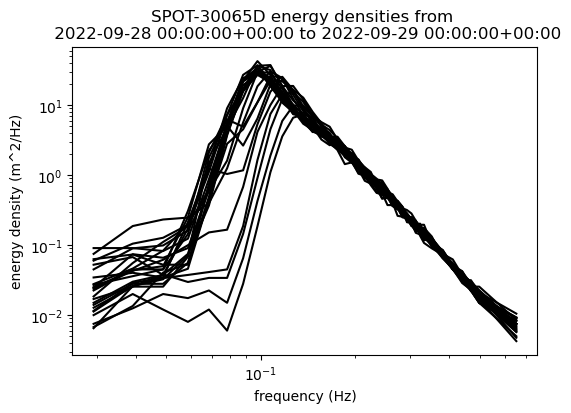

In [7]:
# example: plot energy as a function of frequency over the specified
# datetimes (a loop is the easiest way to do this)
fig, ax = plt.subplots(figsize=(6,4))
for E,f in zip(spotter[spotter_id][start_date:end_date]['energy_density'],
               spotter[spotter_id][start_date:end_date]['frequency']):
    ax.plot(f, E, color='k')

ax.set_ylabel('energy density (m^2/Hz)')
ax.set_xlabel('frequency (Hz)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_title(f'{spotter_id} energy densities from \n {start_date} to {end_date}')